
# Term 1 Project 4 _FindingLanes

We'll first define some image process functions, and then build the lane finding system on the videos 

In [55]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import glob
%matplotlib inline
### 1. Define Image process functions
# Calibration 
def calibration(img_path, CBCorner_width, CBCorner_height):
    objpoints = []
    imgpoints = []
    # Define the desired corner point coordinates, from (0,0,0) to (8,5,0) where z axile is always 0.
    objcorner = np.zeros((CBCorner_width*CBCorner_height,3), np.float32)
    objcorner[:, 0:2] = np.mgrid[0:CBCorner_width, 0:CBCorner_height].T.reshape(-1,2)
    # Read in the calibration image file name
    img_cli = glob.glob('camera_cal/calibration*.jpg')
    # Fetch the camering corner point coordinates per image
    for idx, fname in enumerate(img_cli):
        img = mpimg.imread(fname) # RGB
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # Stack the desired and distorted corner points in one place
        if ret == True: 
            objpoints.append(objcorner)
            imgpoints.append(corners)
    # 1.2 Calibration
    img_calib = mpimg.imread(img_cli[0])
    img_size = (img_calib.shape[1], img_calib.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return ret, mtx, dist, rvecs, tvecs

# Edge detection via color and gradient filtering 
def color_gradient_threshold(img, sx_thresh=(0, 255), sc_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float32)
    H_channel, L_channel, S_channel = hls[:,:,0], hls[:,:,1], hls[:,:,2]

    sobel_x = cv2.Sobel(S_channel, cv2.CV_64F, 1, 0)
    sbs_sx = np.absolute(sobel_x)
    scaled_sx = np.uint8(255*sbs_sx/np.max(sbs_sx))
    # gradient thresholding on x axile
    sx_binary = np.zeros_like(scaled_sx)
    sx_binary[(scaled_sx > sx_thresh[0]) & (scaled_sx <= sx_thresh[1])] = 1
    # color thresholding on hls's S color
    sc_binary = np.zeros_like(S_channel)
    sc_binary[(S_channel > sc_thresh[0]) & (S_channel <= S_channel[1])] = 1
    # combined above two threshold into one colored image
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(sx_binary==1) | (sc_binary==1)] = 1
    
    return combined_binary

# Perspective Transform
### remember, src, dst setting not done yet ###
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[244,695],[1053,688],[563,475],[715,470]])
    des = np.float32(([[340,700],[1030,700],[340,200],[1030,200]]))
    M = cv2.getPerspectiveTransform(src, des)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped



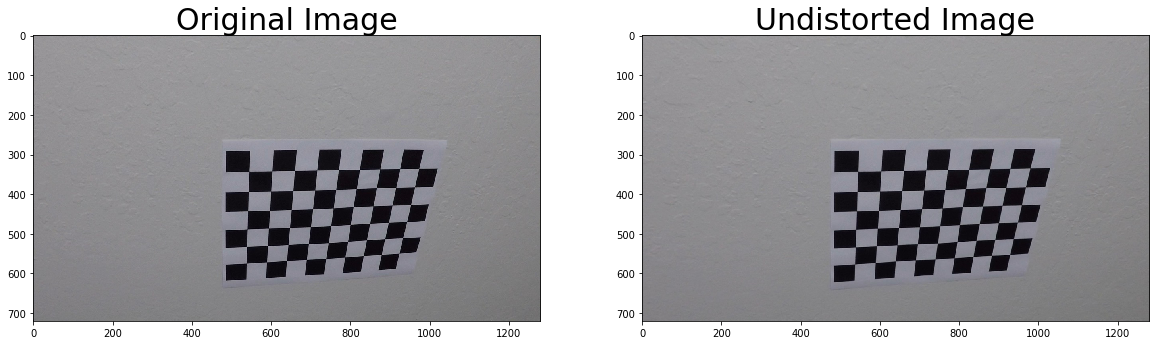

In [56]:
### Function test - calibration & undistortion
# calibration
ret, mtx, dist, rvecs, tvecs = calibration("camera_cal/", 9, 6)
# undistortion
img_cli = glob.glob('camera_cal/calibration*.jpg')
img_calib = mpimg.imread(img_cli[1])
undistort = cv2.undistort(img_calib, mtx, dist, None, mtx)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_calib)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort)
ax2.set_title('Undistorted Image', fontsize=30)


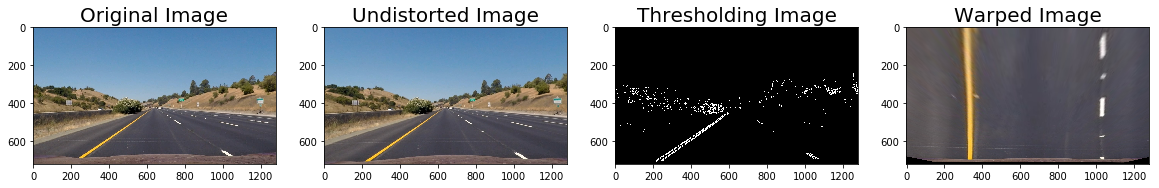

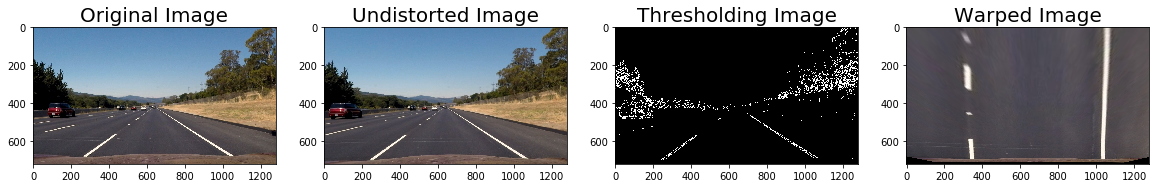

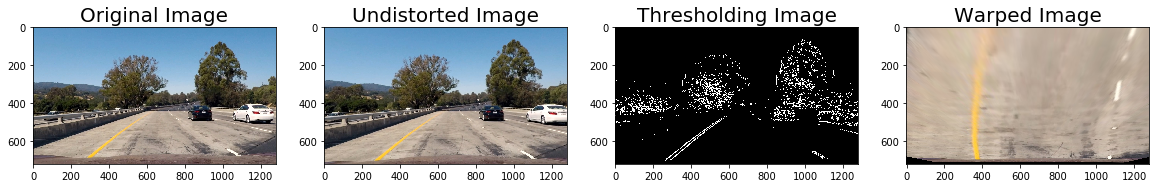

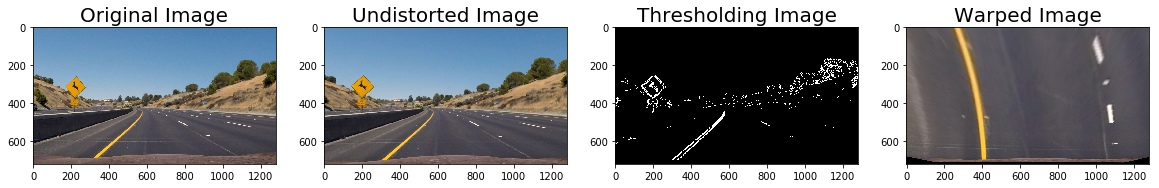

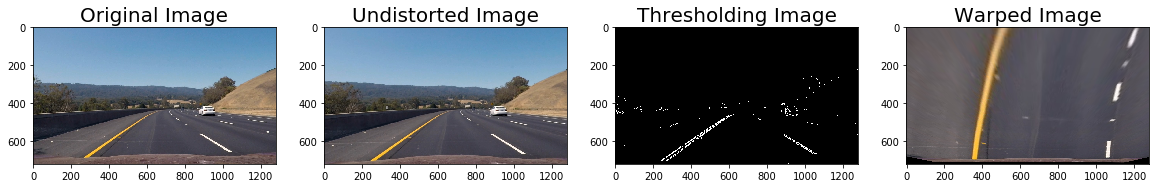

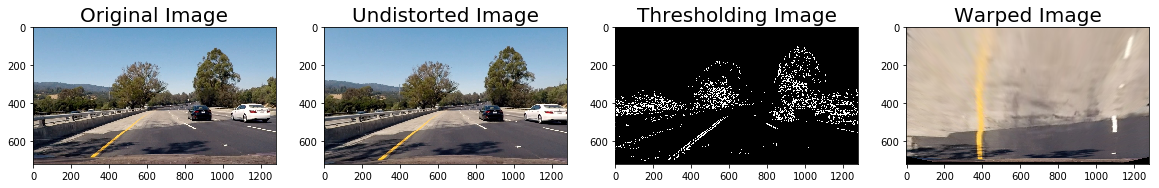

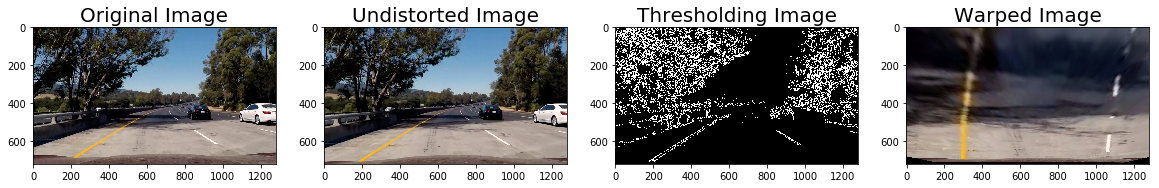

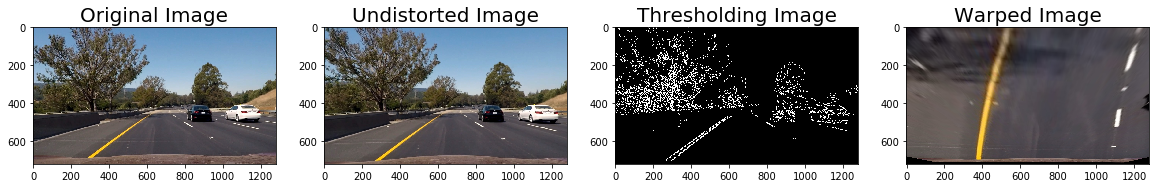

In [58]:
### Function test - color & gradient
sx_thresh = (20,120)
sc_thresh = (170,255)

for img in os.listdir("test_images/"):
    image_origin = mpimg.imread("test_images/"+img)
    image = np.copy(image_origin)
    img_size = (image.shape[1], image.shape[0])
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    combined_binary = color_gradient_threshold(undistort, sx_thresh, sc_thresh)
    warped = warp(image)

    # Visualize undistortion
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistort)
    ax2.set_title('Undistorted Image', fontsize=20)
    ax3.imshow(combined_binary, cmap='gray')
    ax3.set_title('Thresholding Image', fontsize=20)
    ax4.imshow(warped)
    ax4.set_title('Warped Image', fontsize=20)
    cv2.imwrite("output_images/"+img, undistort)

In [59]:
### 2. Define the pipeline 

def pipeline(img, mtx, dist, sx_thresh, sc_thresh):
    img_size = (img.shape[1], img.shape[0])
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary = color_gradient_threshold(undistort, sx_thresh, sc_thresh)
    warped = warp(color_binary)
    print("Test only: the warped image's shape is:", warped.shape)
    return warped

Test only: the warped image's shape is: (720, 1280)


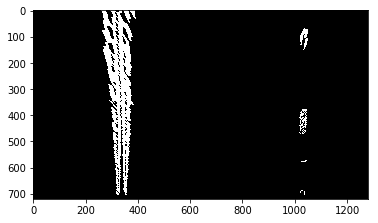

Test only: the warped image's shape is: (720, 1280)


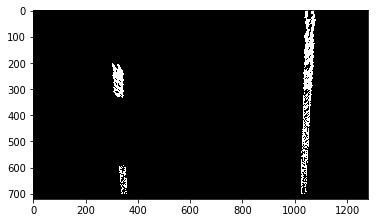

Test only: the warped image's shape is: (720, 1280)


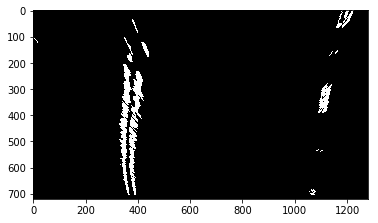

Test only: the warped image's shape is: (720, 1280)


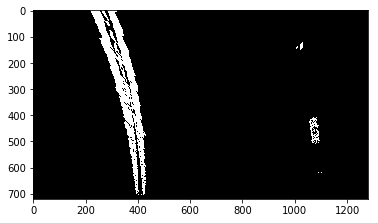

Test only: the warped image's shape is: (720, 1280)


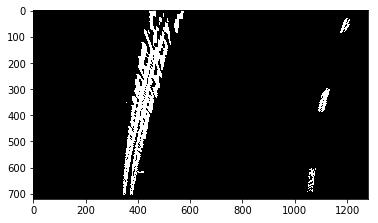

Test only: the warped image's shape is: (720, 1280)


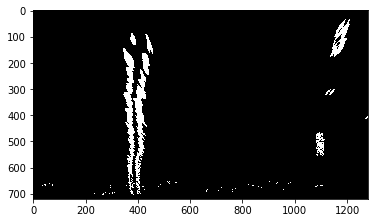

Test only: the warped image's shape is: (720, 1280)


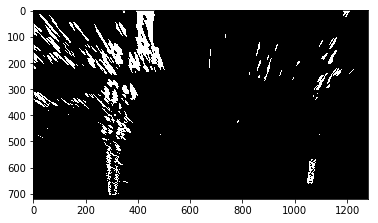

Test only: the warped image's shape is: (720, 1280)


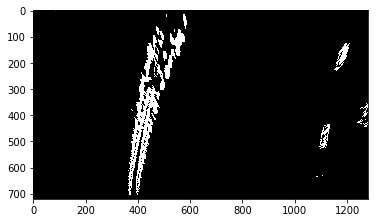

In [60]:
### 3. Test on images
# Calibration
#ret, mtx, dist, rvecs, tvecs = calibration("camera_cal/", 9, 6)
sx_thresh = (20,100)
sc_thresh = (170,255)

for img in os.listdir("test_images/"):
    image_origin = mpimg.imread("test_images/"+img)
    image = np.copy(image_origin)
    binary_warped = pipeline(image, mtx, dist, sx_thresh, sc_thresh)

    plt.imshow(binary_warped, cmap='gray')
    plt.show()
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    cv2.imwrite("output_images/binary_warped/"+img, out_img)

(720, 1280)


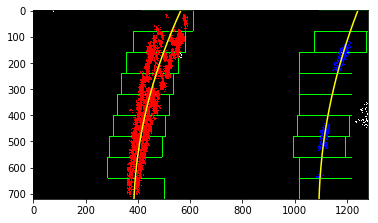

In [66]:
def line_fit(binary_warped):
    # the input image was assumbed to be binary_warped 1 channel images
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0),2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0),2)
    
        #plt.imshow(out_img)
        #plt.show()
        #print(out_img.dtype)
        
        good_left_inds = ((nonzerox > win_xleft_low) & (nonzerox<win_xleft_high) & (nonzeroy>win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox > win_xright_low) & (nonzerox<win_xright_high) & (nonzeroy>win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        #print("now is under %s, in winder %s" % (img, window))
        #print(good_left_inds)

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds) 

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # function line_fit Visualization
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty, rightx] = [0,0,255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return left_fit,right_fit
    
image_origin = cv2.imread("output_images/binary_warped/test6.jpg",0)
plt.imshow(image_origin, cmap='gray')
binary_warped = np.copy(image_origin)
print(binary_warped.shape)
(left_fit, right_fit) = line_fit(binary_warped)



In [67]:
def line_draw(binary_warped, left_fit, right_fit):
    # the input image was assumbed to be binary_warped 1 channel images
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2] - margin)) & (nonzerox < (left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2] - margin)) & (nonzerox < (right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Visualize
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    cv2.imwrite()
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    

In [ ]:
### 3. Test on images

for img in os.listdir("output_images/binary_warped/"):
    image_origin = cv2.imread("output_images/binary_warped/"+img,0)
    binary_warped = np.copy(image_origin)

    # draw the lane lines
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    #print("Now is under:",img)
    #print("binary_warped", binary_warped.shape)
    #print("out_img", out_img.shape)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin        
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0),2)
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0),2)
    
        #plt.imshow(out_img)
        #plt.show()
        #print(out_img.dtype)
        
        good_left_inds = ((nonzerox > win_xleft_low) & (nonzerox<win_xleft_high) & (nonzeroy>win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox > win_xright_low) & (nonzerox<win_xright_high) & (nonzeroy>win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        print("now is under %s, in winder %s" % (img, window))

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds) 

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0,1280)
    plt.ylim(720,0)
    plt.show()

The left and right curvatures are: 613.87824843 m, 1092.38804735 m


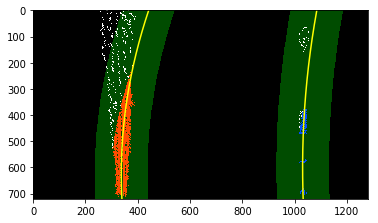

The left and right curvatures are: 2349.2843063 m, 21474.7102799 m


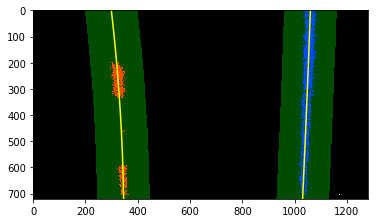

The left and right curvatures are: 7478.2800379 m, 4256.96623731 m


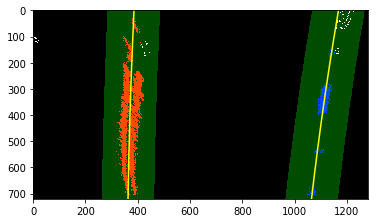

The left and right curvatures are: 1536.39332352 m, 379.001935759 m


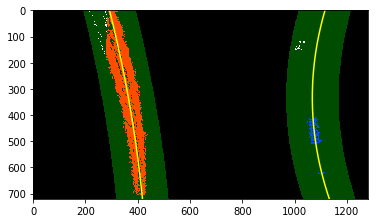

The left and right curvatures are: 680.61493949 m, 809.089518009 m


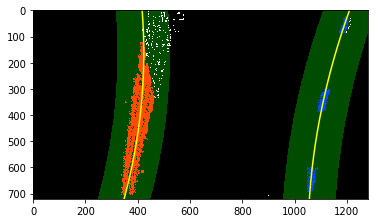

The left and right curvatures are: 1626.0066604 m, 2733.43754218 m


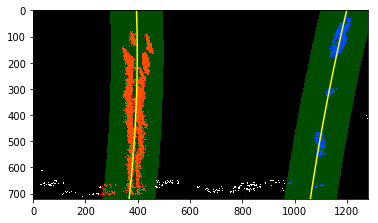

The left and right curvatures are: 2083.66087737 m, 1015.81863083 m


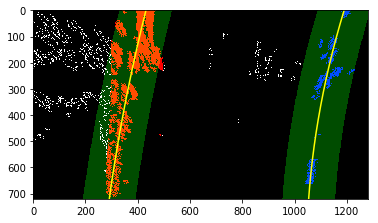

The left and right curvatures are: 1429.04297172 m, 666.240196762 m


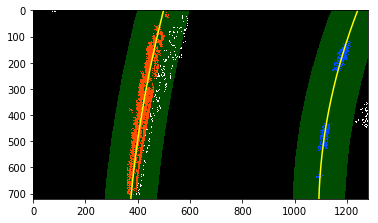

In [68]:
for img in os.listdir("output_images/binary_warped/"):
    image_origin = mpimg.imread("output_images/binary_warped/"+img)
    binary_warped = np.copy(image_origin)
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2] - margin)) & (nonzerox < (left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2] - margin)) & (nonzerox < (right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Calculate the curvature
    y_eval = np.max(ploty)
    left_curvature = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curvature = ((1+ (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define the conversions in x and y from pixels space to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    # Fit new polynomials to x,y in world space
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    print("The left and right curvatures are: %s m, %s m" % (left_curverad, right_curverad))
    #Visualize
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    
    

Now the curves was marked, what's next?